<div style="display:inline;"><div style="text-align:left;">University Mohammed VI<br>
Polytechnic (UM6P)<br>
College of computing<br>
</div>
<div style="text-align:right;">
Année: 2023-2024<br>
</div>
</div>

**Student Name**: DOSSEH AMECK GUY-MAX DESIRE

# <center> Lab 5: Linear Models for Classification</center> 

The [Fashion-MNIST dataset](https://www.openml.org/d/40996) contains 70,000 images of Zalando fashion products, classified into 10 types of clothing, each represented by 28 by 28 pixel values. We's see how well we can classify these with linear models. Let's start with looking at our data:

<div style="text-align:center;">
<img src="https://avatars.mds.yandex.net/i?id=aeaf85b0706d5ea4f02974518d1df2ec202f5b66-12149948-images-thumbs&n=13" width=1000, height=600>
</div>

In [52]:
# General imports
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import openml as oml
import sklearn
import matplotlib
import seaborn as sns 

from matplotlib import cm

# Hide convergence warning for now
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter(action="ignore", category=ConvergenceWarning)

from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


from print_versions import print_versions
# libraries versions
print_versions(globals())

# python version
import sys
print(sys.version)

pandas==2.0.3
numpy==1.24.4
openml==0.14.2
sklearn==1.3.2
matplotlib==3.7.5
seaborn==0.13.2
3.8.18 (default, Sep 11 2023, 13:39:12) [MSC v.1916 64 bit (AMD64)]


In [3]:
# Download FMINST data. Takes a while the first time.
fmnist = oml.datasets.get_dataset(40996)
X, y, _, _ = fmnist.get_data(target=fmnist.default_target_attribute);
fmnist_classes = {0:"T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat", 5: "Sandal",
                  6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle boot"}

C:\Users\duamelo\AppData\Local\Temp\ipykernel_3648\937206066.py:2: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  fmnist = oml.datasets.get_dataset(40996)


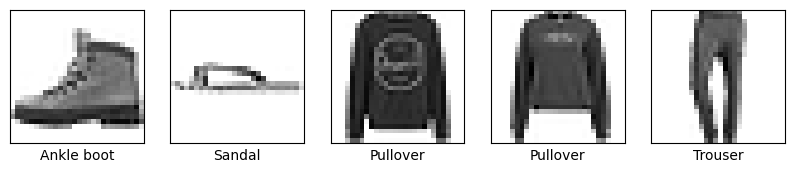

In [4]:
# Take some random examples, reshape to a 32x32 image and plot
from random import randint
fig, axes = plt.subplots(1, 5,  figsize=(10, 5))
for i in range(5):
    n = randint(0,70000)
    axes[i].imshow(X.values[n].reshape(28, 28), cmap=plt.cm.gray_r)
    axes[i].set_xlabel((fmnist_classes[int(y.values[n])]))
    axes[i].set_xticks(()), axes[i].set_yticks(())
plt.show();

## Exercise 1: A quick benchmark
First, we'll try the default [Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) and [Linear SVMs](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html?highlight=linearsvc#sklearn.svm.LinearSVC). Click the links to read the documentation. We'll also compare it to [k-Nearest Neighbors](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) as a point of reference. To see whether our models are overfitting, we also evaluate the training set error. This can be done using [`cross_validate`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html) instead of  [`cross_val_scores`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score).

For now we are just interested in a quick approximation, so we don't use the full dataset for our experiments. Instead, we use 10% of our samples:

In [5]:
# Take a 10% stratified subsample to speed up experimentation
Xs, _, ys, _ = train_test_split(X,y, stratify=y, train_size=0.1)

With this small sample of our data we can now train and evaluate the three classifiers.

### Exercise 1.1
Implement a function below which evaluates each classifier passed into it on the given data, and then returns both the train and test scores of each as a list. You are allowed to import additional functions from whichever module you like, but you should be able to complete the function with [`cross_validate`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html) function and standard Python built-ins. Below the function you will find example output.

In [6]:
def evaluate_learners(classifiers, X, y):
    """ Evaluate each classifier in 'classifiers' with cross-validation on the provided (X, y) data.

    Given a list of scikit-learn classifiers [Classifier1, Classifier2, ..., ClassifierN] return two lists:
     - a list with the scores obtained on the training samples for each classifier,
     - a list with the test scores obtained on the test samples for each classifier.
     The order of scores should match the order in which the classifiers were originally provided. E.g.:
     [Classifier1 train score, ..., ClassifierN train score], [Classifier1 test score, ..., ClassifierN test score]
    """
    train_scores = []
    test_scores = []
    
    for classifier in classifiers:
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        scores = cross_validate(classifier, X, y, cv=skf,
                         scoring=('accuracy'),
                         n_jobs=-1,
                         return_train_score=True)
        train_scores.append(scores["train_score"])
        test_scores.append(scores["test_score"])
    return train_scores, test_scores

# # Example output:
# train_scores, test_scores = ([[0.92 , 0.924, 0.916, 0.917, 0.921],  # Classifier 1 train score for each of 5 folds.
#                               [0.963, 0.962, 0.953, 0.912, 0.934],  # Classifier 2 train score for each of 5 folds.
#                               [0.867, 0.868, 0.865, 0.866, 0.866]], # Classifier 3 train score for each of 5 folds.
#                              [[0.801, 0.811, 0.806, 0.826, 0.804],  # Classifier 1 test score for each of 5 folds.
#                               [0.766, 0.756, 0.773, 0.756, 0.741],  # Classifier 2 test score for each of 5 folds.
#                               [0.804, 0.814, 0.806, 0.821, 0.806]]) # Classifier 3 test score for each of 5 folds.

### Exercise 1.2
Call the function you created with a Logistic Regression, Linear SVM, and k-Nearest Neighbors Classifier.
Store the return values in the variables `train_scores` and `test_scores`. Then, run the code given below to produce a plot visualizing the scores.

In [7]:
# Dummy code. Replace with the actual classifiers and scores
classifiers = [LogisticRegression(n_jobs=-1, random_state=32), LinearSVC(random_state=34), KNeighborsClassifier(n_jobs=-1)]

pipelines = [Pipeline([("pca", PCA(n_components=0.95, random_state=23)), ("classifier", classifier)]) for classifier in classifiers]

train_scores, test_scores = evaluate_learners(pipelines, Xs, ys)#[[0.6,0.7,0.8]], [[0.5,0.6,0.7]]
train_scores_no_pca, test_scores_no_pca = evaluate_learners(classifiers, Xs, ys)

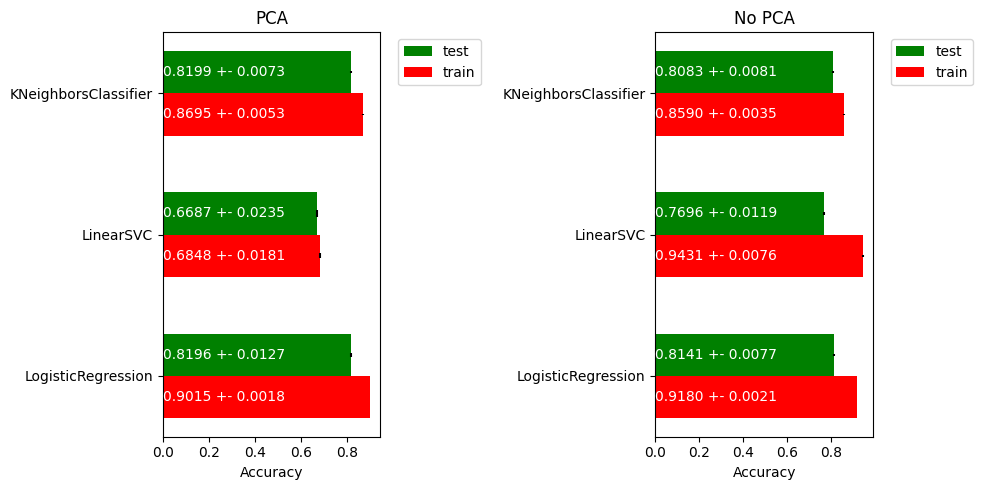

In [8]:
# Plot a bar chart of the train and test scores of all the classifiers, including the variance as error bars
fig, axs = plt.subplots(figsize=(10, 5), nrows=1, ncols=2)
width=0.3
axs[0].barh(np.arange(len(train_scores)), np.mean(test_scores, axis=1), width,
        yerr= np.std(test_scores, axis=1), color='green', label='test')
axs[0].barh(np.arange(len(train_scores))-width, np.mean(train_scores, axis=1), width,
        yerr= np.std(train_scores, axis=1), color='red', label='train')
for i, te, tr in zip(np.arange(len(train_scores)),test_scores,train_scores):
    axs[0].text(0, i, "{:.4f} +- {:.4f}".format(np.mean(te),np.std(te)), color='white', va='center')
    axs[0].text(0, i-width, "{:.4f} +- {:.4f}".format(np.mean(tr),np.std(tr)), color='white', va='center')
axs[0].set(yticks=np.arange(len(train_scores))-width/2, yticklabels=[c.__class__.__name__ for c in classifiers])
axs[0].set_xlabel('Accuracy')
axs[0].legend(bbox_to_anchor=(1.05, 1), loc=2)
axs[0].set_title("PCA")

axs[1].barh(np.arange(len(train_scores_no_pca)), np.mean(test_scores_no_pca, axis=1), width,
        yerr= np.std(test_scores_no_pca, axis=1), color='green', label='test')
axs[1].barh(np.arange(len(train_scores_no_pca))-width, np.mean(train_scores_no_pca, axis=1), width,
        yerr= np.std(train_scores_no_pca, axis=1), color='red', label='train')
for i, te, tr in zip(np.arange(len(train_scores_no_pca)),test_scores_no_pca,train_scores_no_pca):
    axs[1].text(0, i, "{:.4f} +- {:.4f}".format(np.mean(te),np.std(te)), color='white', va='center')
    axs[1].text(0, i-width, "{:.4f} +- {:.4f}".format(np.mean(tr),np.std(tr)), color='white', va='center')
axs[1].set(yticks=np.arange(len(train_scores_no_pca))-width/2, yticklabels=[c.__class__.__name__ for c in classifiers])
axs[1].set_xlabel('Accuracy')
axs[1].legend(bbox_to_anchor=(1.05, 1), loc=2)
axs[1].set_title("No PCA")

plt.suptitle
plt.tight_layout()
plt.show()

### Exercise 1.3
Interpret the plot. Which is the best classifier? Are any of the models overfitting? If so, what can we do to solve this? Is there a lot of variance in the results?

+ With `PCA`:
    - `KNeighborsClassifier` is the best model
    - Yes, `LogisticRegression` is overfitting a little bit
    - Getting more data or doing some regularization could help to deal with overfitting issues.
    - The `LinearSVC` is fitting right with little of **underfitting** compared to the other models

+ Without `PCA`:
    - `LogistRegression` is the best model
    - `Linear SVC` is clearly overfitting. Tuning hyperparameters could also solve this issue.

## Exercise 2: Regularization
We will now tune these algorithm's main regularization hyperparameter: the misclassification cost in SVMs (C), the regularization parameter in logistic regression (C), and the number of neighbors (n_neighbors) in kNN. We expect the optimum for the C parameters to lie in $[10^{-12},10^{12}]$ and for n_neighbors between 1 and 50. C should be varied on a log scale (i.e. [0.01, 0.1, 1, 10, 100]) and k should be varied uniformly (i.e. [1,2,3,4]).

### Exercise 2.1
Vary the regularization parameters in the range given above and, for each classifier, create a line plot that plots both the training and test score for every value of the regularization hyperparameter. Hence, you should produce 3 plots, one for each classifier. Use the default 5-fold cross validation for all scores, but only plot the means.

Hints:
* Think about the time complexity of these models. Trying too many hyperparameter values may take too much time.
* You can make use of numpy's [logspace](https://docs.scipy.org/doc/numpy/reference/generated/numpy.logspace.html), [geomspace](https://docs.scipy.org/doc/numpy/reference/generated/numpy.geomspace.html?highlight=geomspace#numpy.geomspace), and [linspace](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linspace.html#numpy.linspace) functions.
* You can use matplotlib's default [plot](https://matplotlib.org/tutorials/introductory/pyplot.html) function to plot the train and test scores.
* You can manually loop over the hyperparameter ranges, or you can already check out scikit-learn's [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) function to save some programming. We'll see it again later in the course.


In [15]:
param_grid = {'classifier__C': np.logspace(-12, 12, 100)}
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
grid_search_model = GridSearchCV(pipelines[0], param_grid, cv=skf, n_jobs=-1, 
                                 return_train_score=True)

grid_res = grid_search_model.fit(Xs, ys)
    
results = pd.DataFrame(grid_res.cv_results_)

In [17]:
results[["mean_train_score", "mean_test_score", "param_classifier__C", "std_train_score", "std_test_score"]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   mean_train_score     100 non-null    float64
 1   mean_test_score      100 non-null    float64
 2   param_classifier__C  100 non-null    object 
 3   std_train_score      100 non-null    float64
 4   std_test_score       100 non-null    float64
dtypes: float64(4), object(1)
memory usage: 4.0+ KB


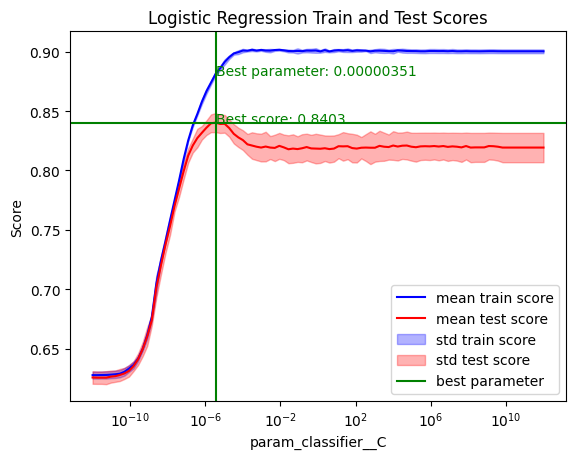

In [83]:
# plot train and test scores
best_param = results.loc[results['mean_test_score'].idxmax()]['param_classifier__C']
best_score = results['mean_test_score'].max()

results["param_classifier__C"] = results["param_classifier__C"].astype(float)
radius = 1e12

indices = results.loc[(results['mean_test_score'] > best_score - radius) & (results['mean_test_score'] < best_score + radius)].index.tolist()


param_name = 'param_classifier__C'
model_name = 'Logistic Regression'

plt.plot(results.loc[indices, param_name], results.loc[indices, 'mean_train_score'], label='mean train score', color='blue')
plt.plot(results.loc[indices, param_name], results.loc[indices, 'mean_test_score'], label='mean test score', color='red')

plt.fill_between(results.loc[indices, param_name], results.loc[indices, 'mean_train_score'] + results.loc[indices, 'std_train_score'],
                 results.loc[indices, 'mean_train_score'] - results.loc[indices, 'std_train_score'], alpha=0.3, color='blue',
                 label='std train score')

plt.fill_between(results.loc[indices, param_name], results.loc[indices, 'mean_test_score'] + results.loc[indices, 'std_test_score'], 
                 results.loc[indices, 'mean_test_score'] - results.loc[indices, 'std_test_score'], alpha=0.3, color='red',
                 label='std test score')

plt.title(f'{model_name} Train and Test Scores')
plt.xlabel(param_name)
plt.ylabel('Score')


# add vertical line for best parameter
plt.axvline(x=best_param, color='green', label='best parameter')
plt.text(best_param, best_score+0.04, f'Best parameter: {best_param:.8f}', color='green')

# add horizontal line for best score
plt.axhline(y=best_score, color='green')
plt.text(best_param, best_score, f'Best score: {best_score:.4f}', color='green')

plt.xscale('log')
plt.legend()

plt.show()

In [104]:
(84.03-81.96)/81.96

0.02525622254758428

- The graph above shows the change in logistic regression accuracy with respect to the change of the regularization parameter.
- The optimal regularization parameter is **3.51e-6** for an accuracy of **84.03%**: This represents an increase by around **2.6%** of the benchmark accuracy of this model, **81.96%**.
- For lower values (<1e-10) of the regularization parameter, we observe an underfitting of the model with little uncertainties on the test score.
- For regularization parameter values between 1e-10 and 1e-6, the accuracy of the model increases with almost no uncertainties.
- For values of `C` above 1e-6, the model tends to overfit, having almost no uncertainties in train set average accuracy and high uncertainties in test average accuracy.

In [40]:
param_grid = {'classifier__C': np.logspace(-12, 12, 15)}
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
grid_search_model = GridSearchCV(pipelines[1], param_grid, cv=skf, n_jobs=-1, 
                                 return_train_score=True)

grid_res_svc = grid_search_model.fit(Xs, ys)
    
results_svc = pd.DataFrame(grid_res_svc.cv_results_)

c:\Users\duamelo\.conda\envs\openml_env\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


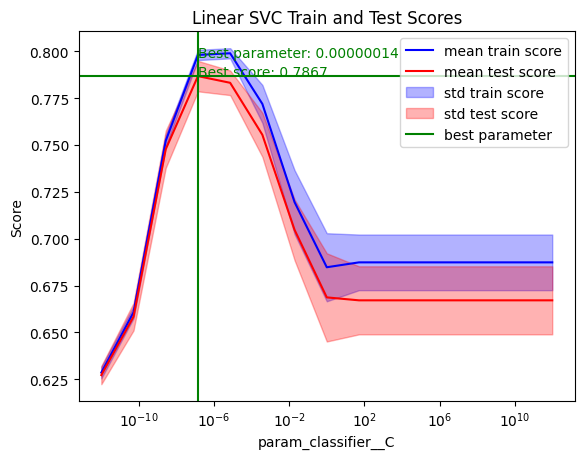

In [120]:
# plot train and test scores
best_param = results_svc.loc[results_svc['mean_test_score'].idxmax()]['param_classifier__C']
best_score = results_svc['mean_test_score'].max()

results_svc["param_classifier__C"] = results_svc["param_classifier__C"].astype(float)
radius = 1e12

indices = results_svc.loc[(results_svc['mean_test_score'] > best_score - radius) & (results_svc['mean_test_score'] < best_score + radius)].index.tolist()


param_name = 'param_classifier__C'
model_name = 'Linear SVC'

plt.plot(results_svc.loc[indices, param_name], results_svc.loc[indices, 'mean_train_score'], label='mean train score', color='blue')
plt.plot(results_svc.loc[indices, param_name], results_svc.loc[indices, 'mean_test_score'], label='mean test score', color='red')

plt.fill_between(results_svc.loc[indices, param_name], results_svc.loc[indices, 'mean_train_score'] + results_svc.loc[indices, 'std_train_score'],
                 results_svc.loc[indices, 'mean_train_score'] - results_svc.loc[indices, 'std_train_score'], alpha=0.3, color='blue',
                 label='std train score')

plt.fill_between(results_svc.loc[indices, param_name], results_svc.loc[indices, 'mean_test_score'] + results_svc.loc[indices, 'std_test_score'], 
                 results_svc.loc[indices, 'mean_test_score'] - results_svc.loc[indices, 'std_test_score'], alpha=0.3, color='red',
                 label='std test score')

plt.title(f'{model_name} Train and Test Scores')
plt.xlabel(param_name)
plt.ylabel('Score')


# add vertical line for best parameter
plt.axvline(x=best_param, color='green', label='best parameter')
plt.text(best_param, best_score+0.01, f'Best parameter: {best_param:.8f}', color='green')

# add horizontal line for best score
plt.axhline(y=best_score, color='green')
plt.text(best_param, best_score, f'Best score: {best_score:.4f}', color='green')

plt.xscale('log')
plt.legend()

plt.show()

In [105]:
(78.67-66.87)/66.87

0.1764617915358157

- The graph above shows the change in linear SVC accuracy with respect to the change of the regularization parameter.
- The optimal regularization parameter is **1.4e-7** for an accuracy of **78.67%**: This represents an increase by around **17.6%** of the benchmark accuracy of this model, **66.87%**.
- The model tends to underfit with lower(<1e-8) and higher(>1e-2) values of `C`
- For values of `C` between 1e-8 and 1e-7, the model accuracy increases.
- For values of `C` between 1e-7 and 1e-2, the model accuracy decrases.

In [91]:
param_grid = {'classifier__n_neighbors': np.arange(1, 51)}
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
grid_search_model = GridSearchCV(pipelines[2], param_grid, cv=skf, n_jobs=-1, 
                                 return_train_score=True)

grid_res_knn = grid_search_model.fit(Xs, ys)
    

In [92]:
results_knn = pd.DataFrame(grid_res_knn.cv_results_)

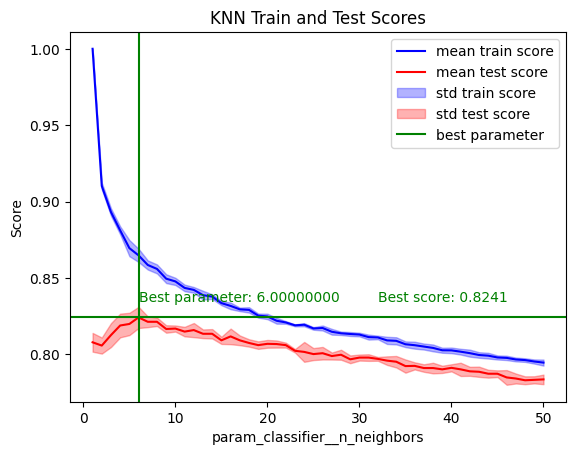

In [103]:
# plot train and test scores
best_param = results_knn.loc[results_knn['mean_test_score'].idxmax()]['param_classifier__n_neighbors']
best_score = results_knn['mean_test_score'].max()

results_knn["param_classifier__n_neighbors"] = results_knn["param_classifier__n_neighbors"].astype(float)
radius = 0.1

indices = results_knn.loc[(results_knn['mean_test_score'] > best_score - radius) & (results_knn['mean_test_score'] < best_score + radius)].index.tolist()


param_name = 'param_classifier__n_neighbors'
model_name = 'KNN'

plt.plot(results_knn.loc[indices, param_name], results_knn.loc[indices, 'mean_train_score'], label='mean train score', color='blue')
plt.plot(results_knn.loc[indices, param_name], results_knn.loc[indices, 'mean_test_score'], label='mean test score', color='red')

plt.fill_between(results_knn.loc[indices, param_name], results_knn.loc[indices, 'mean_train_score'] + results_knn.loc[indices, 'std_train_score'],
                 results_knn.loc[indices, 'mean_train_score'] - results_knn.loc[indices, 'std_train_score'], alpha=0.3, color='blue',
                 label='std train score')

plt.fill_between(results_knn.loc[indices, param_name], results_knn.loc[indices, 'mean_test_score'] + results_knn.loc[indices, 'std_test_score'], 
                 results_knn.loc[indices, 'mean_test_score'] - results_knn.loc[indices, 'std_test_score'], alpha=0.3, color='red',
                 label='std test score')

plt.title(f'{model_name} Train and Test Scores')
plt.xlabel(param_name)
plt.ylabel('Score')


# add vertical line for best parameter
plt.axvline(x=best_param, color='green', label='best parameter')
plt.text(best_param, best_score+0.01, f'Best parameter: {best_param:.8f}', color='green')

# add horizontal line for best score
plt.axhline(y=best_score, color='green')
plt.text(best_param+26, best_score+0.01, f'Best score: {best_score:.4f}', color='green')


plt.legend()

plt.show()

In [106]:
(82.41-81.99)/81.99

0.005122575923893179

- The graph above shows the change in KNeighbors classifier accuracy with respect to the change of the number of neighbors(k).
- The optimal numbe rof neighbor is **6** for an accuracy of **82.41%**: This represents an increase by around **0.5%** of the benchmark accuracy of this model, **81.99%**.
- For lower values (<6) of the number of neighbors, we observe an underfitting of the model with a lot of uncertainties on the test score.
- For number of neighbors above 6, the accuracy of the model decreacreases with almost no uncertainties: Values of `k` between **10 and 20** seems also to be adequate values of this hyperparameter.

### Exercise 2.2
Interpret the plots. When are the methods underfitting? When are they overfitting? How sensitive are they to the regularization hyperparameter?

## Exercise 3: Interpreting misclassifications
Chances are that your models are not yet perfect. It is important to understand what kind of errors it still makes. Let's take a closer look at which instances are misclassified and which classes are often confused.
Train the logistic regression model with `C=1e-7`. Train the model on a training set, and make predictions for a test set (both sets should be  sampled from our 10% subsample).

In [112]:
# Create a stratified train-test split on a sample
X_train, X_test, y_train, y_test = train_test_split(Xs,ys, stratify=ys, random_state=0)

lr = LogisticRegression(C=1e-7, n_jobs=-1, random_state=32)

lr.fit(X_train, y_train)

preds = lr.predict(X_test)

print(classification_report(y_test, preds, target_names=fmnist_classes.values()))

# sns.heatmap(confusion_matrix(y_test, preds), annot=True, fmt='d', cmap='Blues', cbar=False, 
#             xticklabels=fmnist_classes.values(), yticklabels=fmnist_classes.values())   

              precision    recall  f1-score   support

 T-shirt/top       0.81      0.86      0.83       175
     Trouser       0.97      0.95      0.96       175
    Pullover       0.66      0.65      0.66       175
       Dress       0.84      0.87      0.85       175
        Coat       0.64      0.79      0.71       175
      Sandal       0.96      0.73      0.83       175
       Shirt       0.60      0.41      0.49       175
     Sneaker       0.79      0.87      0.83       175
         Bag       0.91      0.92      0.92       175
  Ankle boot       0.81      0.92      0.86       175

    accuracy                           0.80      1750
   macro avg       0.80      0.80      0.79      1750
weighted avg       0.80      0.80      0.79      1750



- The above screening shows a classification report of our logistic regression model: it has an accuracy of around **80%**.

    - The category with the lowest **F1 Score** is `Shirt`, the model has difficulties to correctly distinguish it from some of the other classes.
    - The model best recognizes **Trousers** with a **F1 Score** of **96%**
    

### Exercise 3.1
Train the classifier as described above, obtain the predictions `y_pred` on the test set, and identify all the misclassified samples `misclassified_samples`. Then, run the visualization code below to study the misclassifications

In [71]:
# Implement the code to obtain the actual predictions on the test set
y_pred = preds # dummy values, replace y_test with the actual predictions

# Implement the code to obtain the indices of the misclassified samples
# Example output:
# misclassified_samples = [  11,   12,   14,   23,   30,   34,   39,   46,   50,   52,   55]
y_test = y_test.reset_index(drop=True)
y_pred = np.int64(y_pred)
misclassified_samples = y_test.loc[y_test!=y_pred].index.tolist()#[0,1,2,3,4] # dummy values

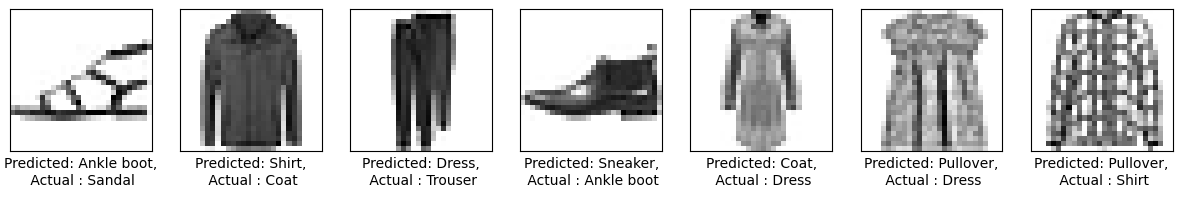

In [99]:
# Visualize the (first five) misclassifications, together with the predicted and actual class
fig, axes = plt.subplots(1, 7,  figsize=(15, 7))
for nr, i in enumerate(misclassified_samples[:7]):
    axes[nr].imshow(X_test.values[i].reshape(28, 28), cmap=plt.cm.gray_r)
    axes[nr].set_xlabel("Predicted: %s,\n Actual : %s" % (fmnist_classes[int(y_pred[i])],fmnist_classes[int(y_test.values[i])]))
    axes[nr].set_xticks(()), axes[nr].set_yticks(())

plt.show();

### Exercise 3.2
Interpret the results. Are these misclassifications to be expected?

- The model misclassifies:

    + Sandals as Ankle boots
    + Coats as shirts
    + Trousers as dresses
    + Ankle boots as sneakers
    + Dresses as coats, or pullovers
    + Shirts as pullovers


- Yes, they are expected for multiple plausible reasons:
    
    + The pictures are blurry
    + The model based its decison on the shape of the clothe on the picture
    + The model tends to consider the distribution of the pixels: Similar shapes tends to have similar distributions.

### Exercise 3.3.
Run the code below on your results to draw the complete confusion matrix and get more insight on the systematic misclassifications
of your model. A confusion matrix shows the amount of examples in for each pair of true and predicted classes. Interpret the results.
Does your model produce certain types of error more often than other types?

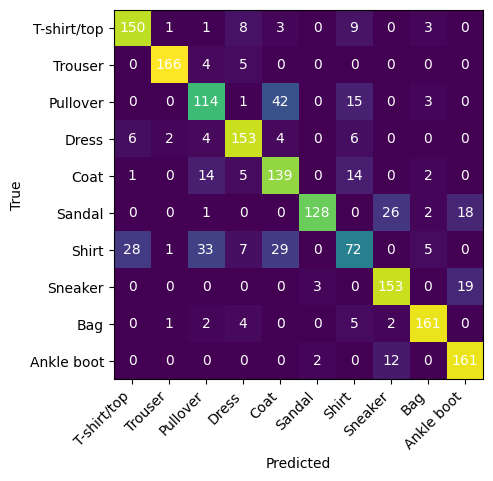

In [76]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,y_pred)
fig, ax = plt.subplots()
im = ax.imshow(cm)
ax.set_xticks(np.arange(10)), ax.set_yticks(np.arange(10))
ax.set_xticklabels(list(fmnist_classes.values()), rotation=45, ha="right")
ax.set_yticklabels(list(fmnist_classes.values()))
ax.set_ylabel('True')
ax.set_xlabel('Predicted')
for i in range(100):
    ax.text(int(i/10),i%10,cm[i%10,int(i/10)], ha="center", va="center", color="w")

In [123]:
# get true positive, false positive, true negative, false negative of the model multiclass classification
def get_confusion_matrix_values(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    tp = np.diag(cm)
    fp = np.sum(cm, axis=0) - tp
    fn = np.sum(cm, axis=1) - tp
    tn = np.sum(cm) - (fp + fn + tp)
    return tp, fp, tn, fn

tp, fp, tn, fn = get_confusion_matrix_values(y_test, y_pred)
print(f"The model has {round(sum(tp), 2)}% True Positives, {round(sum(fp), 2)}% False Positives, {round(sum(tn), 2)}% True Negatives, and {round(sum(fn), 2)}% False Negatives.")

The model has 7.98% True Positives, 2.02% False Positives, 87.98% True Negatives, and 2.02% False Negatives.


- The confusion matrix shows that the model misclassifies almost all the classes: some more than others.
- We have **2.02**% of False Positive (Type I erorr) as well as **2.02%** of False negaive(Type II errors): Thus the model doesn't produre more of a specific type error.

## Exercise 4: Interpreting model parameters
Finally, we'll take a closer look at the model parameters, i.e. the coefficients of our linear models. Since we are dealing with 28x28 pixel images, we have to learn 784 coefficients. What do these coefficients mean? We'll start by plotting them as 28x28 pixel images.

### Exercise 4.1
Train a Logistic Regression model and a Linear SVM using their tuned hyperparameters from exercise 2.
When in doubt, use `C=1e-7` for LogReg and `C=1e-8` for the SVM.
Pass the trained model to the provided plotting function. Interpret the results in detail.
Why do you get multiple plots per model? What do the features represent in your data.
Does it seems like the models pay attention to the right features?
Do you models seem to ignore certain features? Do you observe differences in quality between the different classes? Do you observe any differences between the models?

In [77]:
# Plots the coefficients of the given model as 28x28 heatmaps.
# The `name` attribute is optional, it is simply a title for the produced figure
def plot_coefficients(model, name=None):
    fig, axes = plt.subplots(1,10,figsize=(20,2))
    fig.suptitle(name if name else model.__class__.__name__)
    for i, ax in enumerate(axes):
        m = ax.imshow(model.coef_[i].reshape(28,28))
        ax.set_xlabel(fmnist_classes[i])
        ax.set_xticks(()), ax.set_yticks(())
    fig.colorbar(m, ax=axes.ravel().tolist())

In [124]:
lr.coef_.shape

(10, 784)

c:\Users\duamelo\.conda\envs\openml_env\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


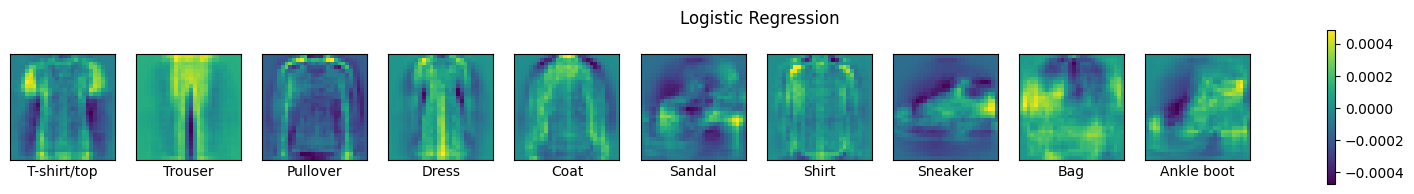

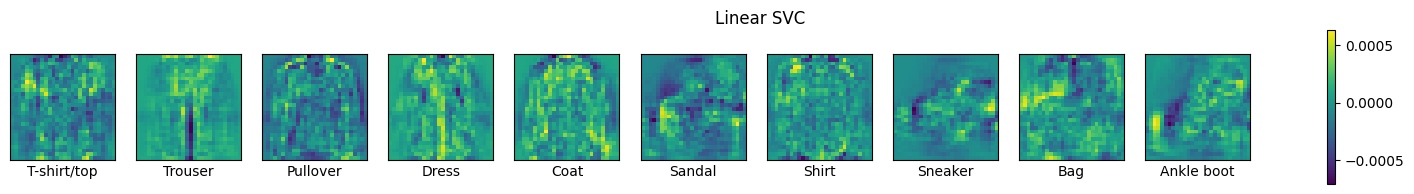

In [82]:
plot_coefficients(lr, "Logistic Regression")

# svc
svc = LinearSVC(C=1e-7, random_state=34)
svc.fit(X_train, y_train)
plot_coefficients(svc, "Linear SVC")

- **SKLEARN Logist Regression Documentation**
```
coef_ndarray of shape (1, n_features) or (n_classes, n_features)
Coefficient of the features in the decision function.

coef_ is of shape (1, n_features) when the given problem is binary. In particular, when multi_class='multinomial', coef_ corresponds to outcome 1 (True) and -coef_ corresponds to outcome 0 (False).
```
- **Interpret the results in detail.**

    + By reshaping the weight to image dimension (28, 28), we have an idea of how the model "perceives" a given object.
    
    + So on the above plot for each subplot(corresponding to each class of our ploblem), we can see the weights associated like an image. It tends to look like the real image with some discrpancies.

- **Why do you get multiple plots per model?**

    +  The above graph plots the coefficients of the model which are of shape (number of classes=10, number features/pixels=784). If a class is predicted with the highest probability, its corresponding weights are used to make the predictions by mulplying it by the pixels values and then applying an "activation function"(Logistic, SVM,...).


- **What do the features represent in your data.**

    + The pixels of the the pictures

- **Does it seems like the models pay attention to the right features?**

    + Sometimes not, for example it doesn't pays attention to buttons on shirts, to details on bags, to opennes of the sandals...
    + It mostly pays care to the shape of the objects

- **Do your models seem to ignore certain features?**

    + Yes, it does.

- **Do you observe differences in quality between the different classes?**

    + The quality of representation of sandals and bags are very low compared to dresses and trousers

- **Do you observe any differences between the models?**

    + Yes, the representation in the `SVC` model are more blurry than in the `Logistic Regression` one: Thus the last one better captures the variance in the features.

    + We can assume that the regularization leads to  a loss in quality of the pictures.

### Exercise 4.2
Repeat the previous exercise, but now only with logistic regression. In addition to a tuned version, also add a model that overfits a lot and one that underfits a lot. Interpret and explain the results.

Best C               Underfit                Overfit           
  train_score test_score train_score test_score train_score test_score
0    0.906667      0.828       0.324   0.330857    0.916762   0.813714

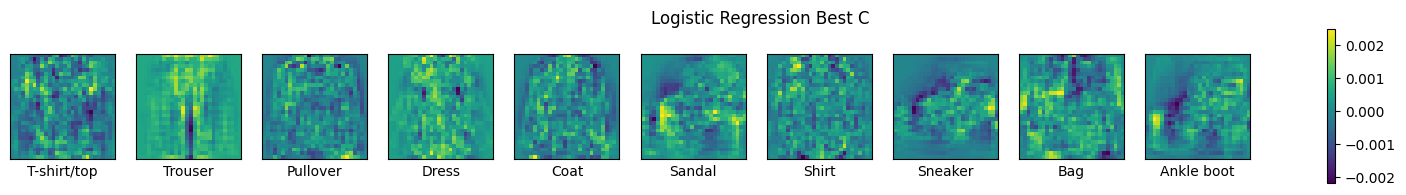

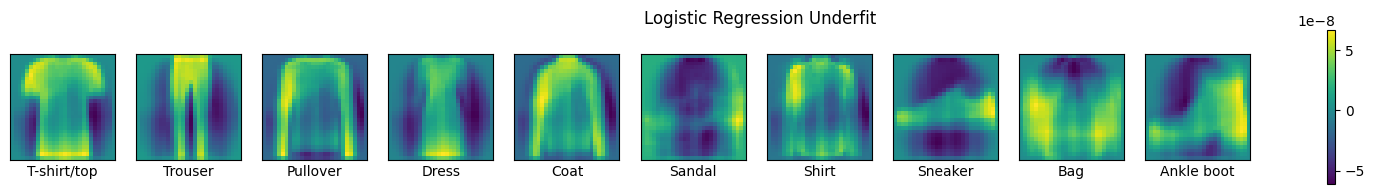

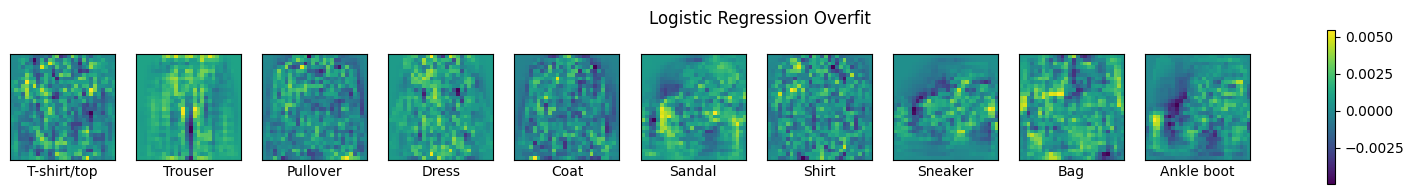

In [90]:
# best C lr
lr_best = LogisticRegression(C=grid_res.best_params_["classifier__C"], n_jobs=-1, random_state=32)
lr_best.fit(X_train, y_train)
plot_coefficients(lr_best, "Logistic Regression Best C")

# display lr_best train and test scores as df
# import display
train_score = accuracy_score(y_train, lr_best.predict(X_train))
test_score = accuracy_score(y_test, lr_best.predict(X_test))
df_best = pd.DataFrame({"train_score": [train_score], "test_score": [test_score]})

# underfit lr
lr_underfit = LogisticRegression(C=1e-12, n_jobs=-1, random_state=32)
lr_underfit.fit(X_train, y_train)
plot_coefficients(lr_underfit, "Logistic Regression Underfit")

# display lr_underfit train and test scores as df
train_score = accuracy_score(y_train, lr_underfit.predict(X_train))
test_score = accuracy_score(y_test, lr_underfit.predict(X_test))
df_underfit = pd.DataFrame({"train_score": [train_score], "test_score": [test_score]})

# overfit lr
lr_overfit = LogisticRegression(C=1e12, n_jobs=-1, random_state=32)
lr_overfit.fit(X_train, y_train)
plot_coefficients(lr_overfit, "Logistic Regression Overfit")
df_overfit = pd.DataFrame({"train_score": [accuracy_score(y_train, lr_overfit.predict(X_train))], 
                           "test_score": [accuracy_score(y_test, lr_overfit.predict(X_test))]})
# display lr_overfit train and test scores as df
train_score = accuracy_score(y_train, lr_overfit.predict(X_train))
test_score = accuracy_score(y_test, lr_overfit.predict(X_test))

# concatenate all dataframes and add 2nd column index
df = pd.concat([df_best, df_underfit, df_overfit], keys=["Best C", "Underfit", "Overfit"], axis=1)
# multi index from ["Best C", "Underfit", "Overfit"] and ["train_score", "test_score"]
df.columns = pd.MultiIndex.from_product([["Best C", "Underfit", "Overfit"], ["train_score", "test_score"]])
df


- **Interpret and explain the results.**

    + **The model with the best `C`** captures the shape of the object but is a little blurry, shown as an image.
    + **The model underfitting** while represented, at the forefront the form of the objects; but in the background, there are shadows of the other objects: It has difficulties to distinguish between objects: we can assume that it could mix sneakers and coats. The weights of this model range from -5e-8 to 5e8, and thus are close to 0. The model tends to penalize all the features.
    + **The model overfitting** when represented, better captures the variance in the different objects with weights ranging from -0.0025 and 0.0050.